# PS04#03 Implementing GPs

<div style="text-align: right;font-size: 0.8em">Last updated: 2023-01-12</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

np.random.seed(123456)

## Part 1: Sampling from a GP
As a running example for a covariance function, we will use the Squared Exponential (SE) covariance function. Recall that it is defined as
$$
k: \mathbb{X}\times\mathbb{X}\rightarrow\mathbb{R},
\quad 
k(x,x')=\sigma_\mathrm{f}\exp\left(-\frac{\|x-x'\|^2}{2\ell^2}\right),
$$
where $\mathbb{X}\subseteq\mathbb{R}^D$ and $\sigma_\mathrm{f}>0$ is the signal variance and $\ell>0$ is the lengthscale. Note that the SE covariance function is sometimes called the Gaussian covariance function or kernel and that sometimes a different definition of lengthscale is used (e.g., including the square or including the 2). In FML, we will only use the definition given in the lecture.

### Starting very simple
#### Question 1
**Subquestion a)** Implement a function that evaluates the SE kernel. It should be able to accept numpy arrays, in particular, if $x1$ is a $N\times 1$ and $x2$ a $1\times M$ array, then it should return an $N\times M$ array with $k((x1)_i,(x2)_j)$ at position $(i,j)$.

In [2]:
def se_kernel_1d(x1, x2, ell=1, sigma_f=1):
    ### BEGIN SOLUTION
    return sigma_f*np.exp(-(x1-x2)**2/(2*ell**2))
    ### END SOLUTION

Recall that $f \sim \mathcal{GP}(m,k)$ means that $f$ is a random function.
In particular, drawing a sample from a GP means sampling a realization of this random function (often called a _sample path_), which is therefore a real-valued function on $\mathbb{X}$. In general, $\mathbb{X}$ will be an infinite set (usually even uncountable), so it is impossible to actually fully sample such a random function.

When sampling from a GP and plotting such a sample, what we actually do is sampling on finite subset  $\tilde{\mathbb{X}}\subseteq\mathbb{X}$. Formally, we do not sample a realization of $f \sim \mathcal{GP}(m,k)$, but of the restriction to $\tilde{\mathbb{X}}$.

How to do this? Let $\tilde{\mathbb{X}}=\{x_1,\ldots,x_P\}\subseteq\mathbb{X}$, then we can interpret the restriction of $f$ to this set as a random vector $(f(x_1),\ldots,f(x_P))^\top$. But according to the definition of a GP, this random vector is then just a multivariate normal random variable with mean $(m(x_1),\ldots,m(x_2))^\top$ and covariance matrix $(k(x_j,x_i))_{i,j=1,\ldots,P}$. Note that this matrix is also called _kernel matrix_. We therefore have reduced the problem of sampling from a GP to sampling from a multivariate normal distribution, which is a standard task implemented for example in numpy.

Let us now demonstrate this on a simple example. Consider $f\sim\mathcal{GP}(0,k)$, where $k$ is the SE kernel on $\mathbb{X}=\mathbb{R}$ with $\sigma_\mathrm{f}=1$ and $\ell=0.25$. For $\tilde{\mathbb{X}}$ we choose a uniform grid of 100 points from $[-1,1]$.

**Subquestion b)** Compute the covariance matrix $K=((k_j,k_i))_{i,j=1,\ldots,100}$ and plot it as an image plot. Interpret this plot.

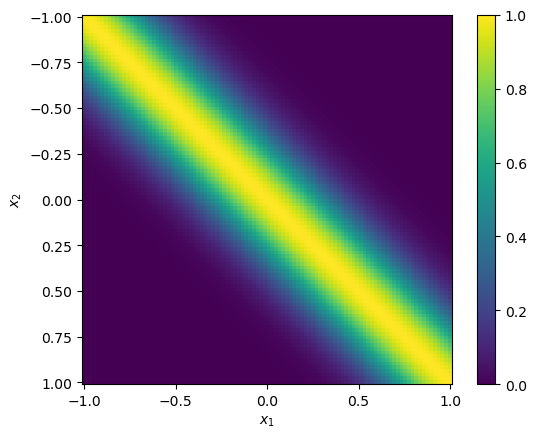

In [3]:
# xs The grid
# K The covariance matrix
### BEGIN SOLUTION
xs = np.linspace(-1,1,100)
K = se_kernel_1d(xs.reshape([-1,1]), xs.reshape([1,-1]), ell=0.25)

plt.figure()
plt.gca().set_aspect('equal', 'box')
plt.pcolormesh(xs, xs, K, shading='nearest')
plt.gca().invert_yaxis()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
_ = plt.colorbar()
### END SOLUTION

**Subquestion c)** Draw a single sample from the GP and plot it (in the sense outlined above).

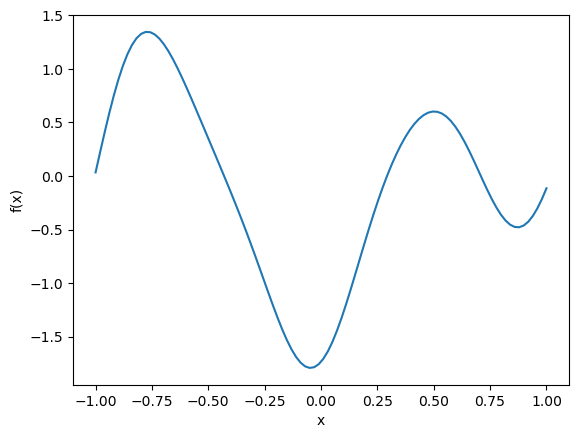

In [4]:
### BEGIN SOLUTION
ys = np.random.multivariate_normal(np.zeros_like(xs), K)

plt.plot(xs,ys)
plt.xlabel('x')
_ = plt.ylabel('f(x)')
### END SOLUTION

**Subquestion d)** To get a better intuition, plot only every 8th, 4th, 2th, every point of this sample. How would the plots look like if you call the random generator instead of just subsampling the given sample?

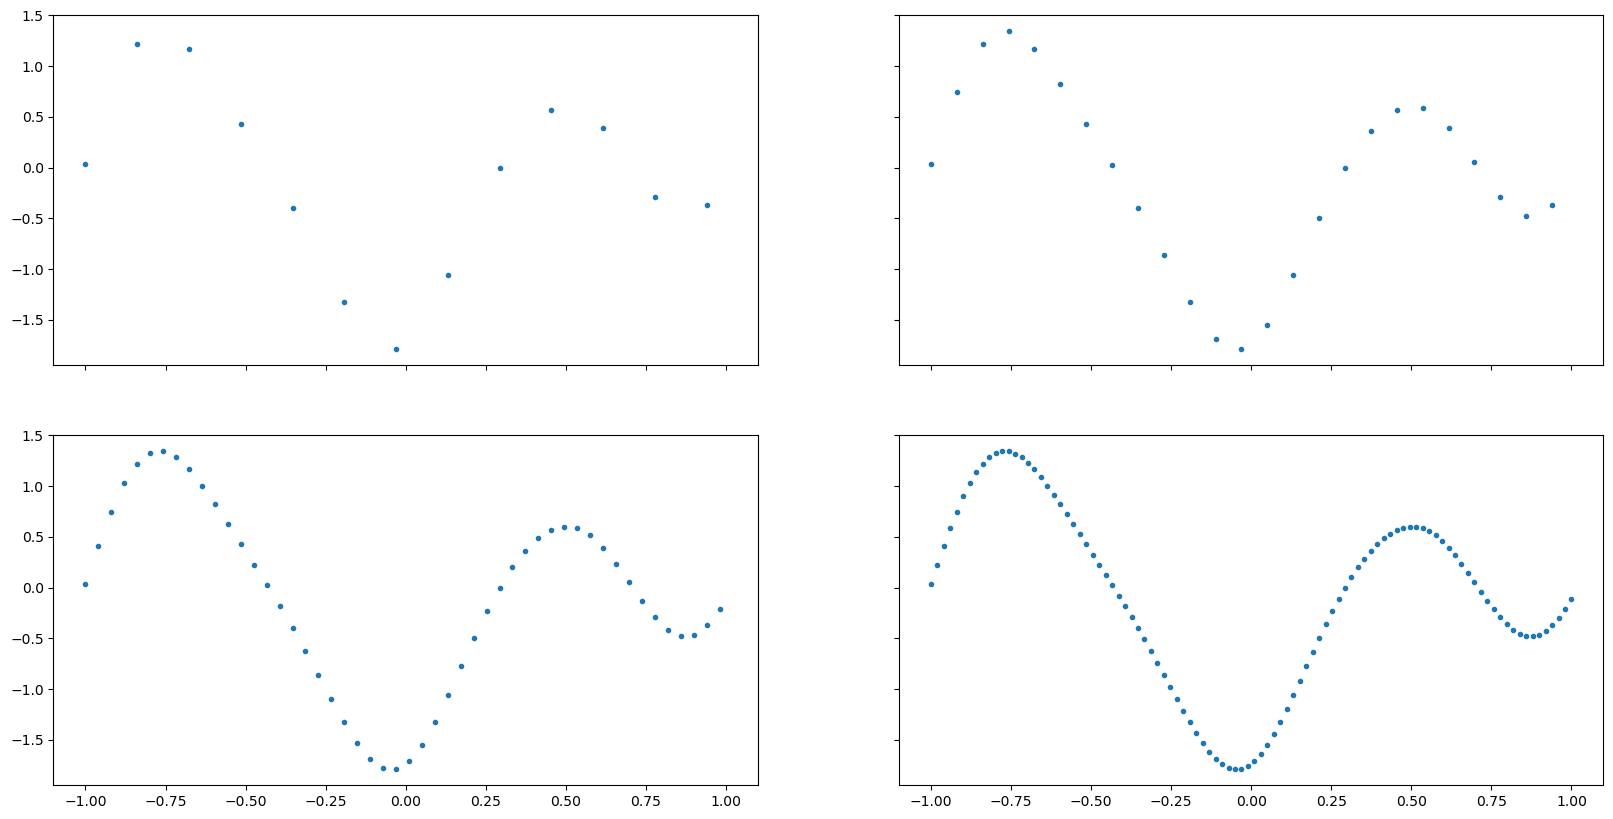

In [5]:
### BEGIN SOLUTION
fig, axs = plt.subplots(2,2, figsize=(20,10), sharex="all", sharey="all")
for i in range(4):
    axs[i // 2, i % 2].plot(xs[::2**(3-i)], ys[::2**(3-i)], '.')
### END SOLUTION

**Subquestion e)** Now draw 4 independent samples from the GP and plot them in the same figure.

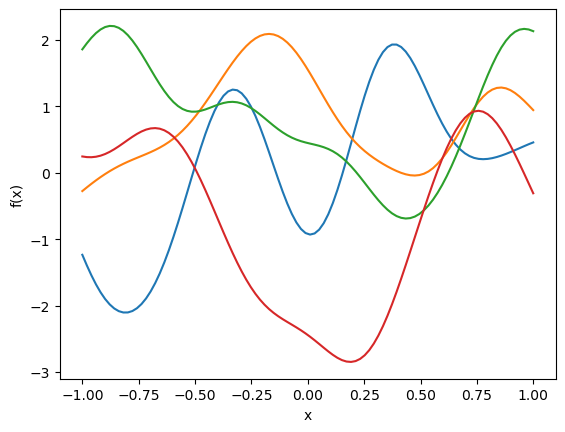

In [6]:
### BEGIN SOLUTION
ys = np.random.multivariate_normal(np.zeros_like(xs), K, 4)
for i in range(4):
    plt.plot(xs, ys[i,:])
plt.xlabel('x')
_ = plt.ylabel('f(x)')
### END SOLUTION

**Excursion** We just saw that in order to draw samples from a GP, we need to be able to draw samples from a multivariate normal distribution. Assume you have access to a function that can draw $N$ i.i.d. samples of $\mathcal{N}(0,1)$. For concreteness, take `np.random.normal(size=N)`. Implement a function that uses this latter function and can generate a sample from $\mathcal{N}(\mu, \Sigma)$ for given mean vector $\mu\in\mathbb{R}^N$ and positive definite covariance matrix $\Sigma\in\mathbb{R}^{N\times N}$.

In [7]:
def sample_mvn(mu, Sigma):
    ### BEGIN SOLUTION
    L = np.linalg.cholesky(Sigma)
    zs = np.random.normal(size=len(mu))
    return L @ zs + mu
    ### END SOLUTION

#### Question 2
We now turn to more general cases. As a running example, we again use the SE kernel, but this time on $\mathbb{R}^D$. We use a rather inefficient, but instructive approach.

**Subquestion a)** Implement the SE kernel for general $\mathbb{R}^D$ input. For simplicity, it is enough that the function accepts single vectors instead of 2d arrays containing multiple inputs.

In [8]:
def se_kernel(x1, x2, ell=1, sigma_f=1):
    ### BEGIN SOLUTION
    return sigma_f*np.exp(-np.linalg.norm(x1-x2, ord=2)**2/(2*ell**2))
    ### END SOLUTION

**Subquestion b)** Write a function that takes an array of inputs (the first dimension has size number of input points) and a kernel (a function with signature $(x_1,x_2) \mapsto k(x_1,x_2)$) and outputs the corresponding kernel matrix.

In [9]:
def build_kernel_matrix(xs, kernel):
    ### BEGIN SOLUTION
    N = xs.shape[0]
    K = np.zeros([N,N])
    for i in range(N):
        for j in range(i,N):
            K[i,j] = kernel(xs[i],xs[j])
    inds_row, inds_col = np.triu_indices(N,k=1)
    K[inds_col,inds_row] = K[np.triu_indices(N,k=1)]
    return K
    ### END SOLUTION

**Subquestion c)** Write a function that accepts the number of samples $S$ (an integer), an array of $P$ inputs, a mean function $m$ (a function with signature $x \mapsto m(x)$), and a kernel (a function with signature $(x_1,x_2) \mapsto k(x_1,x_2)$) and returns an $S\times P$ array of samples from the corresponding GP $\mathcal{GP}(m,k)$.

In [10]:
def sample_gp(n_samples, xs, kernel, m=None):
    ### BEGIN SOLUTION
    K = build_kernel_matrix(xs, kernel)
    
    if m is not None:
        mean = np.array([m(x) for x in xs]).flatten()
    else:
        mean = np.zeros(xs.shape[0])

    return np.random.multivariate_normal(mean, K, n_samples)
    ### END SOLUTION

**Subquestion d)** Use the function from the previous subquestion to sample 4 paths of a GP with mean function $m(x)=\sin(2\pi x)$, keeping all other settings as in Question 1.

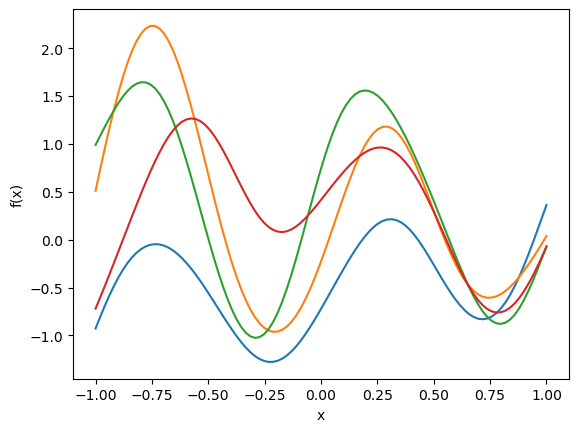

In [11]:
### BEGIN SOLUTION
ys = sample_gp(4, 
               xs.reshape([-1,1]), 
               lambda x1,x2: se_kernel(x1,x2,ell=0.25, sigma_f=0.25), 
               lambda x: np.sin(2*np.pi*x))
for i in range(4):
    plt.plot(xs, ys[i,:])
plt.xlabel('x')
_ = plt.ylabel('f(x)')
### END SOLUTION

## Part 2: Conditioning
Consider a GP prior $f \sim \mathcal{GP}(m,k)$ with mean $m$ and covariance function $k$.

Assume now that we have a data set $(\mathbf{x}_1,\mathbf{y}_1),\ldots,(\mathbf{x}_N,\mathbf{y}_N)$ with $\mathbf{x}_n\in\mathbb{X}$ and $\mathbf{y}_n = f(\mathbf{x}_n)+\epsilon_n$, $n=1,\ldots,N$, where $\epsilon_1,\ldots,\epsilon_N \overset{\text{i.i.d.}}{\sim} \mathcal{N}(0,\sigma_\mathrm{n}^2)$. For convenience we define and 
$$X=\begin{pmatrix} \mathbf{x}_1 & \cdots & \mathbf{x}_N\end{pmatrix},
\qquad
\mathbf{y}=\begin{pmatrix}\mathbf{y}_1 \\ \vdots \\ \mathbf{y}_N\end{pmatrix}.
$$

We want to combine our prior with this data, arriving at the posterior GP.

### Posterior mean and variance
Let $\mathbf{\hat x}\in\mathbb{X}$ be a new test input, and we are interested in the posterior predictive distribution $p(f \mid \mathbf{\hat x}, X, \mathbf{y})$. This means that we want to predict the value $f(\mathbf{\hat x})$.
From the lecture we know that
$p(f \mid \mathbf{\hat x}, X, \mathbf{y})=\mathcal{N}(m_\text{post}(\mathbf{\hat x}), \sigma_\text{post}^2(\mathbf{\hat x}))$ with
$$
m_\text{post}(\mathbf{\hat x}) = m(\mathbf{\hat x}) + K(\mathbf{\hat x}),X)(K(X,X)+\sigma_\mathrm{n}^2I)^{-1}K(X,\mathbf{\hat x})
$$
and
$$
\sigma_\text{post}^2(\mathbf{\hat x}) = k(\mathbf{\hat x},\mathbf{\hat x})
- k(\mathbf{\hat x},X)(K(X,X)+\sigma_\mathrm{n}^2I)^{-1}K(X,\mathbf{\hat x}).
$$
#### Question 3
We implement this now step by step in a very simple setting.
Let $\mathbb{X}=\mathbb{R}$, $m\equiv 0$ and let us use the 1d SE kernel from Question 1, part a) with $\sigma_f=1$ and $\ell=0.4$

**Subquestion a)** Plot the mean and standard deviation of the corresponding GP prior as well as 4 sample paths.

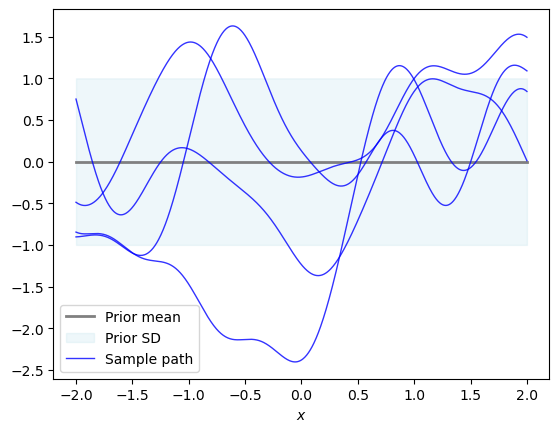

In [12]:
### BEGIN SOLUTION
# Covariance function settings
ell = 0.4
sigma_f = 1

# The grid used for plotting
xs = np.linspace(-2,2,1000)

# The prior mean is trivial in this example
ys_mean = np.zeros_like(xs)

# Prior SD
# Note that the SD is constant here, so the following could also be simplified
ys_sd = np.sqrt(se_kernel_1d(xs, xs, ell=0.4, sigma_f=1))

# Plot mean and SD
plt.plot(xs, ys_mean, lw=2, color='gray', label='Prior mean')
plt.fill_between(xs, ys_mean - ys_sd, ys_mean + ys_sd, color='orange', alpha=0.2, label='Prior SD')

# Sampling and plotting
# We can reuse Question 1 here
# Note that the SD function is not enough, we need the full covariance function
K = se_kernel_1d(xs.reshape([-1,1]), xs.reshape([1,-1]), ell=ell, sigma_f=sigma_f)

# Recall that a sample path corresponds to a realization of a multivariate GRV here
ys = np.random.multivariate_normal(ys_mean, K, 4)

# Plotting the sample paths
for i in range(4):
    plt.plot(xs, ys[i,:], lw=1, color='blue', alpha=0.8)

# Add legend and labels
handles, labels = plt.gca().get_legend_handles_labels()
patch = matplotlib.lines.Line2D([], [], 
                                color='blue', 
                                linewidth=1, 
                                alpha=0.8,
                                label='Sample path')
handles.append(patch)
    
plt.xlabel('$x$')
plt.legend(handles=handles)
### END SOLUTION

**Subquestion b)** We consider now a data set with only one item, $(\mathbf{x}_1,\mathbf{y}_1)=(1,0.5)$. Assuming that $\sigma_\mathrm{n}^2=0.01$, compute the posterior mean and posterior SD at $\mathbf{\hat x}=0$.

In [13]:
### BEGIN SOLUTION
# The data set (just one datum)
x_data = 1
y_data = 0.5

# The noise variance
sigma2_n = 0.01

# The test input
x_pred = 0

# Computing the mean at x_pred=0
mean_post = 0 - se_kernel_1d(x_pred, x_data, ell=ell, sigma_f=sigma_f)/(
    se_kernel_1d(x_data, x_data, ell=ell, sigma_f=sigma_f)+sigma2_n)*y_data

# Computing the SD at x_pred = 0
sd_post = np.sqrt(
    se_kernel_1d(x_pred, x_pred, ell=ell, sigma_f=sigma_f)
    -
     se_kernel_1d(x_pred, x_data, ell=ell, sigma_f=sigma_f)/
    (se_kernel_1d(x_data, x_data, ell=ell, sigma_f=sigma_f)+sigma2_n)
    *se_kernel_1d(x_data, x_pred, ell=ell, sigma_f=sigma_f))

print(f"m_post(0)=${mean_post:.3f}, sigma_post^2(0)={sd_post:.3f}")
### END SOLUTION

m_post(0)=$-0.022, sigma_post^2(0)=0.999


Note that the posterior mean and the posterior variance are actually functions, so the remarks from Question 1 apply. In particular, we cannot plot these functions themselves, but instead only the functions evaluated on a grid.

**Subquestion c)** Plot the posterior mean and posterior SD together with the data point. Observe that we do not need matrix inversion here. Furthermore, add 4 samples from the posterior GP.

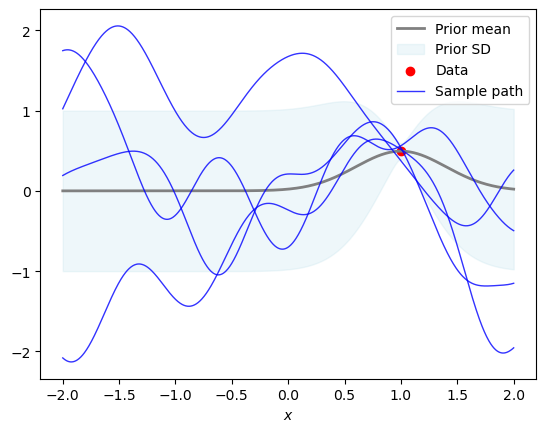

In [14]:
### BEGIN SOLUTION
# Compute the posterior mean on the plotting grid
# Note that only the first factor in the product changes
ys_mean_post = se_kernel_1d(xs, x_data, ell=ell, sigma_f=1)/(
    se_kernel_1d(x_data, x_data, ell=ell, sigma_f=1)+sigma2_n)*y_data

# Compute the posterior SD on the plotting grid
# Observe that only the first term and the outer terms of the product in the second term change
ys_sd_post = np.sqrt(
    se_kernel_1d(xs, xs, ell=ell, sigma_f=1)
    -
     se_kernel_1d(xs, x_data, ell=ell, sigma_f=1)/
    (se_kernel_1d(x_data, x_data, ell=ell, sigma_f=1)+sigma2_n)
    *se_kernel_1d(x_data, xs, ell=ell, sigma_f=1))

# Plot the posterior and SD
plt.plot(xs, ys_mean_post, lw=2, color='gray', label='Prior mean')
plt.fill_between(xs, ys_mean_post - ys_sd_post, ys_mean_post + ys_sd_post, 
                 color='lightblue', 
                 alpha=0.2, 
                 label='Prior SD')

# Add the data point
plt.scatter(x_data, y_data, color='red', label='Data')

# Sampling from posterior
# Again, the posterior SD is not enough, we need the full covariance matrix
Sigma_post = K - se_kernel_1d(xs.reshape([-1,1]), x_data, ell=ell, sigma_f=sigma_f)/(
    se_kernel_1d(x_data, x_data, ell=ell, sigma_f=sigma_f)+sigma2_n)*(
    se_kernel_1d(x_data, xs.reshape([1,-1]), ell=ell, sigma_f=sigma_f))

ys_post = np.random.multivariate_normal(ys_mean_post, Sigma_post, 4)
for i in range(4):
    plt.plot(xs, ys_post[i,:], lw=1, color='blue', alpha=0.8)
    
# Add legend and label
handles, labels = plt.gca().get_legend_handles_labels()
patch = matplotlib.lines.Line2D([], [], 
                                color='blue', 
                                linewidth=1, 
                                alpha=0.8,
                                label='Sample path')
handles.append(patch)
    
plt.legend(handles=handles)
_ = plt.xlabel('$x$')
### END SOLUTION

#### Question 4
We now consider multiple data points in the data set we condition on, say $(\mathbf{x}_1,\mathbf{y}_1),\ldots,(\mathbf{x}_N,\mathbf{y}_N)$. Note that in this case a matrix inversion will be necessary. For numerical reasons, it is better to reformulate this by solving a linear equation system.

Suppose we want to predict at $P$ test inputs $\mathbf{\hat x}_1,\ldots,\mathbf{\hat x}_P\in\mathbb{X}$. Using the notation from the lecture, 
$$X=\begin{pmatrix} \mathbf{x}_1 & \cdots & \mathbf{x}_N \end{pmatrix},
\quad
\mathbf{y}=\begin{pmatrix} \mathbf{y}_1 \\ \vdots \\ \mathbf{y}_N \end{pmatrix},
\hat X=\begin{pmatrix} \mathbf{\hat x}_1 & \cdots & \mathbf{\hat x}_P \end{pmatrix}
$$
this leads to the posterior mean
$$
m_\mathrm{post}(\hat X) = m(\hat X) + K(\hat X,X)(K(X,X)+\sigma_\mathrm{n}^2 I)^{-1}\mathbf{y}
$$
We reformulate this as
$$
m_\mathrm{post}(\hat X) = m(\hat X) + K(\hat X,X)\alpha
$$
where
$$
(K(X,X)+\sigma_\mathrm{n}^2 I)\alpha = \mathbf{y}.
$$


Recall that the posterior variance at one test input is given by
$$
\sigma_\text{post}^2(\mathbf{\hat x}) = k(\mathbf{\hat x},\mathbf{\hat x})
- k(\mathbf{\hat x},X)(K(X,X)+\sigma_\mathrm{n}^2I)^{-1}K(X,\mathbf{\hat x}).
$$
It turns out that for our purposes it is easier to directly work with the posterior covariance matrix at the test inputs
$$
\Sigma_\mathrm{post}(\hat X) = K(\hat X, \hat X) - K(\hat X,X)(K(X,X)+\sigma_\mathrm{n}^2 I)^{-1}K(X,\hat X),
$$
and we get the posterior variance from
$$
\sigma_\mathrm{post}^2(\hat X) = \mathrm{diag}(\Sigma_\mathrm{post}(\hat X).
$$
We reformulate this similarly to
$$
\Sigma_\mathrm{post}(\hat X) = K(\hat X, \hat X) - K(\hat X,X)M
$$
where
$$
(K(X,X)+\sigma_\mathrm{n}^2 I)M = K(X,\hat X).
$$

**Subquestion a)** Implement a function that takes a data set, a mean and covariance function, the noise variance and test inputs and returns the corresponding posterior mean and posterior covariance.

For simplicity, we consider only 1d data.

In [19]:
def compute_posterior(xs_data, ys_data, mean_func, covar_func, sigma2_n, xs_pred):
    """Computes the posterior mean vector and covariance matrix for a GP
    
    Given a data set, mean and covariance function for the prior GP, as well as
    the noise variance, the mean and covariance of the posterior GP evaluated at
    test inputs are returned. The covariance function should accept numpy inputs
    like se_kernel_1d in Question 1.
    
    Args:
        xs_data: A one-dimensional numpy array containing the training inputs
        ys_data: A one-dimensional numpy array containing the training outputs
        mean_func: Mean function of the prior GP, should accept 1d numpy arrays
        covar_func: The covariance function of the prior GP
        sigma2_n: The noise variance (assuming i.i.d. additive centered Gaussian noise)
        xs_pred: A one-dimensional numpy array containing the test inputs
        
    Returns:
        A tuple containing the posterior mean and the posterior covariance
    """
    ### BEGIN SOLUTION
    K = covar_func(xs_data.reshape([-1,1]), xs_data.reshape([1,-1]))
    alpha = np.linalg.solve(K + sigma2_n, ys_data)
    K_left = covar_func(xs_pred.reshape([-1,1]), xs_data.reshape([1,-1]))
                        
    mean_post = mean_func(xs_data) + K_left @ alpha
                 
    K_pred = covar_func(xs_pred.reshape([-1,1]), xs_pred.reshape([1,-1]))
    M = np.linalg.solve(K + sigma2_n, K_left.T)
    Sigma_post = K_pred - K_left @ M
    
    return mean_post, Sigma_post
    ### END SOLUTION

**Subquestion b)** We reuse the GP posterior rom Question 3. Consider the data set $(-1,1), (0.5,-0.5), (1,0.5)$ and assume $\sigma_n^2=0.01$.
Use the function from the previous subquestion to compute the posterior mean and covariance function on a uniform grid on $[-2,2]$.

In [16]:
### BEGIN SOLUTION
xs_data = np.array([-1, 0.5, 1])
ys_data = np.array([1, -0.5, 0.1])

ys_mean_post, Sigma_post = compute_posterior(xs_data, 
                                          ys_data, 
                                          lambda x: 0, 
                                          lambda x1,x2: se_kernel_1d(x1,x2,ell=ell,sigma_f=sigma_f),
                                          0.01,
                                          xs)
### END SOLUTION

**Subquestion c)** Consider the situation of the previous subquestion. Plot the posterior mean and the posterior SD, the data points from the data set, as well as 4 sample paths from the posterior GP.

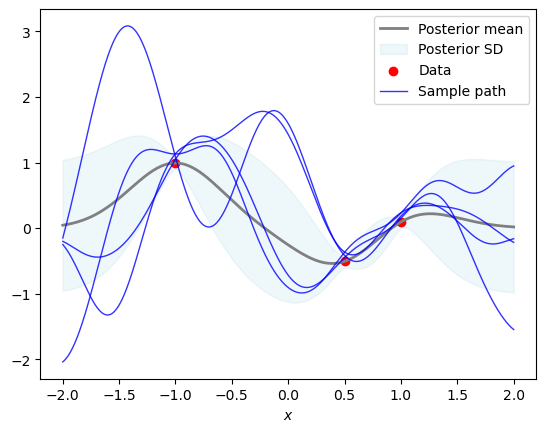

In [17]:
### BEGIN SOLUTION
# Plot the posterior mean
plt.plot(xs, ys_mean_post, lw=2, color='gray', label='Posterior mean')

# Plot the posterior SD
ys_sd_post = np.sqrt(np.diag(Sigma_post))
plt.fill_between(xs, ys_mean_post - ys_sd_post, ys_mean_post + ys_sd_post, 
                 color='lightblue', 
                 alpha=0.2, 
                 label='Posterior SD')

# Add the data points
plt.scatter(xs_data, ys_data, color='red', label='Data')

# Sample 4 paths from the posterior GP and plot them
ys_post = np.random.multivariate_normal(ys_mean_post, Sigma_post, 4)
for i in range(4):
    plt.plot(xs, ys_post[i,:], lw=1, color='blue', alpha=0.8)
    
# Add legend and label
handles, labels = plt.gca().get_legend_handles_labels()
patch = matplotlib.lines.Line2D([], [], 
                                color='blue', 
                                linewidth=1, 
                                alpha=0.8,
                                label='Sample path')
handles.append(patch)
    
plt.legend(handles=handles)
_ = plt.xlabel('$x$')
### END SOLUTION

#### Outlook
Note that the implementations above do not take into account the specific properties and structure of the objects involved. In particular, the kernel matrix $K(X,X)$ is positive semidefinite (and hence $K(X,X)+\sigma_\mathrm{n}^2 I$ is always positive definite for nonzero noise levels $\sigma_\mathrm{n}^2>0$). This can be used in the numerical implementation by utilizing the Cholesky decomposition. Furthermore, as already hinted at in some subquestions above, some intermediate results can and should be reused. For details, see for example Chapter 2, in particular, Algorithm 2.1, in [RW06].

Furthermore, predictions with GP scale unfavorably in the number of data points. This issue can be dealt with by going from exact inference, i.e., using the exact posterior of the GP, to approximate inference. A good starting point is Chapter 8 in [RW06].

Much more on learning with GPs, including practical exercises, can also be found in the Gaussian Process Summer Schools [GPSS].

**References**
[RW06] Rasmussen, Williams, Gaussian Processes for Machine Learning, MIT Press 2006
(available online at https://gaussianprocess.org/gpml/)

[GPSS] Gaussian Process Summer Schools. See for example the 2021 edition at https://gpss.cc/gpss21/